In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib as mpl
import math
import pickle
import matplotlib.patches as mpatches
from tqdm import tqdm
from itertools import zip_longest
from scipy.stats import linregress
from scipy.stats import ks_2samp
import scipy as sp


dat_path = os.getcwd()[:-4] + 'data/'
figures_path = os.getcwd()[:-4] + 'figures/'
prelim_fig_path = os.getcwd()[:-4] + 'figures/preliminary/'
generated_dat_path = os.getcwd()[:-4] + 'data/generated_data/'

text_font = 30

In [37]:
norm_quant = 'Runs'
odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

odi_final.columns

Index(['search_ID', 'Match_ID', 'Match_Date', 'Venue', 'Team', 'Overs', 'Runs',
       'Wickets', 'player_name', 'bat_pos', 'bat_run', 'bat_balls',
       'bat_fours', 'bat_sixes', 'bat_wicket', 'bowl_overs', 'bowl_maiden',
       'bowl_runs', 'bowl_wickets', 'captain', 'wicketkeeper', 'PoM', 'Winner',
       'Batting_Order', 'renormalized_bat_run', 'renormalized_runs',
       'renormalized_bowl_runs', 'team_match_num', 'batsmen', 'bowler',
       'allrounder', 'opp_wickets'],
      dtype='object')

In [38]:
def axis_decor(ax, text_font, major_length, minor_length, linewidth):

    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)

    ax.tick_params(axis='both', which='major', labelsize=text_font, length=major_length, width=linewidth)
    ax.tick_params(axis='both', which='minor', labelsize=text_font, length=minor_length, width=linewidth)

In [39]:
def captain_non_captain_data(min_career, norm_quant, category, min_captain):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    players_list = np.unique(odi_final['player_name'].astype(str))

    captain_category, non_captain_category = [], []

    for player in tqdm(players_list):
        temp_df = odi_final[odi_final['player_name'] == player]
        temp_df = temp_df.sort_values(by='Match_Date')

        if category == 'bat':
            if temp_df['batsmen'].sum() > min_career:
                if temp_df['captain'].sum() > min_captain:
                    captain_category.append(temp_df['renormalized_bat_run'].mean())
                else:
                    non_captain_category.append(temp_df['renormalized_bat_run'].mean())

        if category == 'bowl':
            if temp_df['bowler'].sum() > min_career:
                if temp_df['captain'].sum() > min_captain:
                    captain_category.append(temp_df['bowl_wickets'].mean())
                else:
                    non_captain_category.append(temp_df['bowl_wickets'].mean())

    with open(generated_dat_path + f'captain_non_captain_min_career_{min_career}_renorm_{norm_quant}_{category}_min_captain_{min_captain}.pkl', 'wb') as f:
        pickle.dump([captain_category, non_captain_category], f)

# captain_non_captain_data(min_career=25, norm_quant='Runs', category='bat', min_captain=15)
# captain_non_captain_data(min_career=25, norm_quant='Runs', category='bowl', min_captain=15)

100%|██████████| 2863/2863 [00:16<00:00, 173.98it/s]


bat 122 448
30.612413149771264 25.78486937551059
0.15769889654376193
1.2950033692939189e-11
bowl 50 487
0.9622957908973676 1.1347985802983485
-0.17926171041454644
0.0005112772037721792


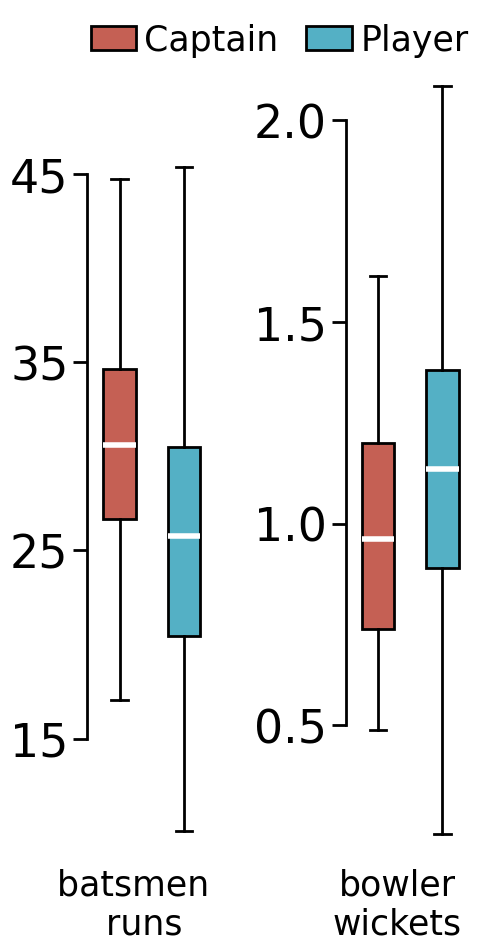

In [40]:
def captain_non_captain_plot(min_career, norm_quant, min_captain):

    fig, ax = plt.subplots(1,2,figsize=(5, 11))
    plt.subplots_adjust(wspace=1, hspace=0.5)
    ax = ax.flatten()

    for i, category in enumerate(['bat', 'bowl']):
        with open(generated_dat_path + f'captain_non_captain_min_career_{min_career}_renorm_{norm_quant}_{category}_min_captain_{min_captain}.pkl', 'rb') as f:
            captain_category, non_captain_category = pickle.load(f)

        
        bplot1 = ax[i].boxplot([captain_category], positions=[1], widths=0.5, 
                    showfliers=False, patch_artist=True, showmeans=False,
                    boxprops=dict(facecolor='#C56054', linewidth=2), 
                    medianprops=dict(color='white', linewidth=0), 
                    whiskerprops=dict(color='black', linewidth=2), 
                    capprops=dict(color='black', linewidth=2))
        bplot2 = ax[i].boxplot([non_captain_category], positions=[2], widths=0.5, 
                    showfliers=False, patch_artist=True, showmeans=False, 
                    boxprops=dict(facecolor='#54B0C5', linewidth=2), 
                    medianprops=dict(color='white', linewidth=0), 
                    whiskerprops=dict(color='black', linewidth=2), 
                    capprops=dict(color='black', linewidth=2))
        
        ax[i].hlines(np.nanmean(captain_category), 0.75, 1.25, color='white', linewidth=4)
        ax[i].hlines(np.nanmean(non_captain_category), 1.75, 2.25, color='white', linewidth=4)
        
        print(category, len(captain_category), len(non_captain_category))
        print(np.nanmean(captain_category), np.nanmean(non_captain_category))
        print((np.nanmean(captain_category)- np.nanmean(non_captain_category))/(np.nanmean(captain_category)))

        captain_category = np.array(captain_category)
        non_captain_category = np.array(non_captain_category)
        captain_category = captain_category[np.isfinite(captain_category)]
        non_captain_category = non_captain_category[np.isfinite(non_captain_category)]

        print(sp.stats.mannwhitneyu(captain_category, non_captain_category).pvalue)
    
        axis_decor(ax[i], text_font+3, 10, 5, 2)

        ax[i].set_xticks([])
        ax[i].set_xticklabels([])
        ax[i].spines['bottom'].set_visible(False)

        if category == 'bat':
            ax[i].set_ylim(5, 50)
            ax[i].set_yticks([15, 25, 35, 45])
            ax[i].spines['left'].set_bounds(15, 45)
            ax[i].set_xlabel('batsmen \n runs', fontsize=text_font-5, horizontalalignment='center')
            ax[i].xaxis.set_label_coords(0.4, 0.07)
        elif category == 'bowl':
            ax[i].set_ylim(0, 2.1)
            ax[i].set_yticks([0.5, 1, 1.5, 2])
            ax[i].spines['left'].set_bounds(0.5, 2)
            ax[i].set_xlabel('bowler\nwickets', fontsize=text_font-5, horizontalalignment='center')
            ax[i].xaxis.set_label_coords(0.4, 0.07)


    fig.legend([bplot1["boxes"][0], bplot2["boxes"][0]], ['Captain', 'Player'], loc='upper right', fontsize=text_font-5, frameon=False, bbox_to_anchor=(0.75,0.76,0.2, 0.2), ncol=2, labelspacing=1, columnspacing=0.8, handletextpad=0.25, handlelength=1.3)

    # plt.tight_layout()
    plt.savefig(prelim_fig_path + f'captain_non_captain_min_career_{min_career}_renorm_{norm_quant}_min_captain_{min_captain}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

captain_non_captain_plot(min_career=25, norm_quant='Runs', min_captain=15)

In [41]:
def captain_division_data(min_career, norm_quant, category, min_captain):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    players_list = np.unique(odi_final['player_name'].astype(str))

    before_captain_category, during_captain_category, after_captain_category = [], [], []

    for player in tqdm(players_list):
        temp_df = odi_final[odi_final['player_name'] == player]
        temp_df = temp_df.sort_values(by='Match_Date')

        if category == 'bat':
            if temp_df['batsmen'].sum() > min_career:
                captain_indices = temp_df[temp_df['captain'] == 1].index.tolist()
                if len(captain_indices) > min_captain:
                    # print(player, len(captain_indices))
                    first_captain_index = captain_indices[0]
                    last_captain_index = captain_indices[-1]
                    before_captain_category.append(temp_df[temp_df.index < first_captain_index]['renormalized_bat_run'].mean())
                    during_captain_category.append(temp_df[(temp_df.index >= first_captain_index) & (temp_df.index <= last_captain_index)]['renormalized_bat_run'].mean())
                    after_captain_category.append(temp_df[temp_df.index > last_captain_index]['renormalized_bat_run'].mean())

        if category == 'bowl':
            if temp_df['bowler'].sum() > min_career:
                captain_indices = temp_df[temp_df['captain'] == 1].index.tolist()
                if len(captain_indices) > min_captain:
                    # print(player, len(captain_indices))
                    first_captain_index = captain_indices[0]
                    last_captain_index = captain_indices[-1]
                    before_captain_category.append(temp_df[temp_df.index < first_captain_index]['bowl_wickets'].mean())
                    during_captain_category.append(temp_df[(temp_df.index >= first_captain_index) & (temp_df.index <= last_captain_index)]['bowl_wickets'].mean())
                    after_captain_category.append(temp_df[temp_df.index > last_captain_index]['bowl_wickets'].mean())

    with open(generated_dat_path + f'captain_before_during_after_min_career_{min_career}_renorm_{norm_quant}_{category}_min_captain_{min_captain}.pkl', 'wb') as f:
        pickle.dump([before_captain_category, during_captain_category, after_captain_category], f)

# captain_division_data(min_career=25, norm_quant='Runs', category='bat', min_captain=15)
# captain_division_data(min_career=25, norm_quant='Runs', category='bowl', min_captain=15)

122 122 122
118 122 64
before-during:  0.030461746547337402
during-after:  9.364623695544527e-14


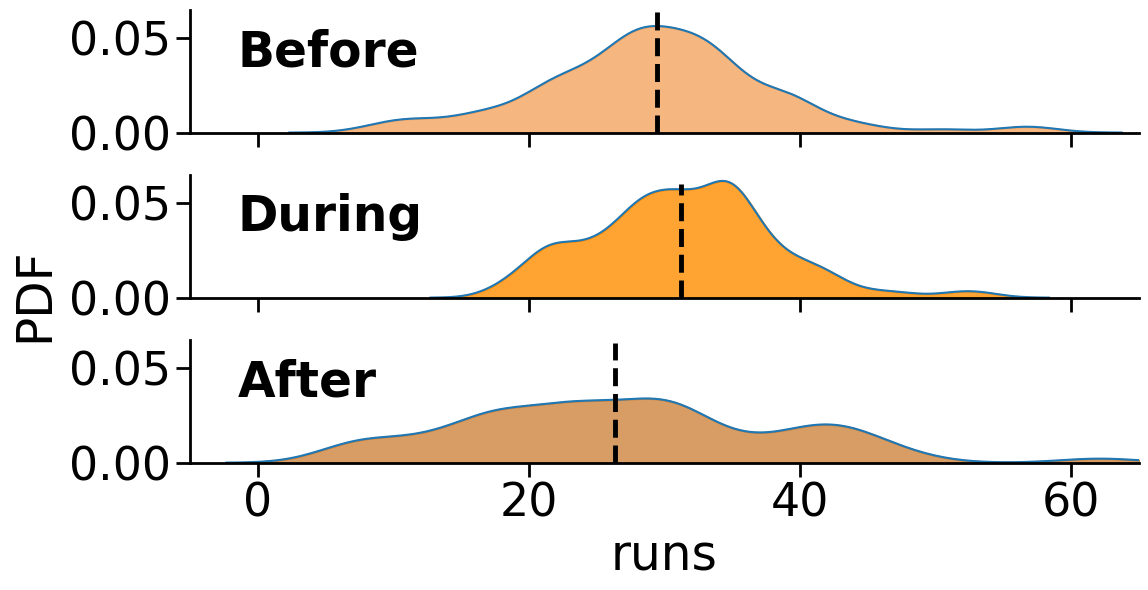

50 50 50
44 50 30
before-during:  0.6728660916951329
during-after:  0.0005822568814776493


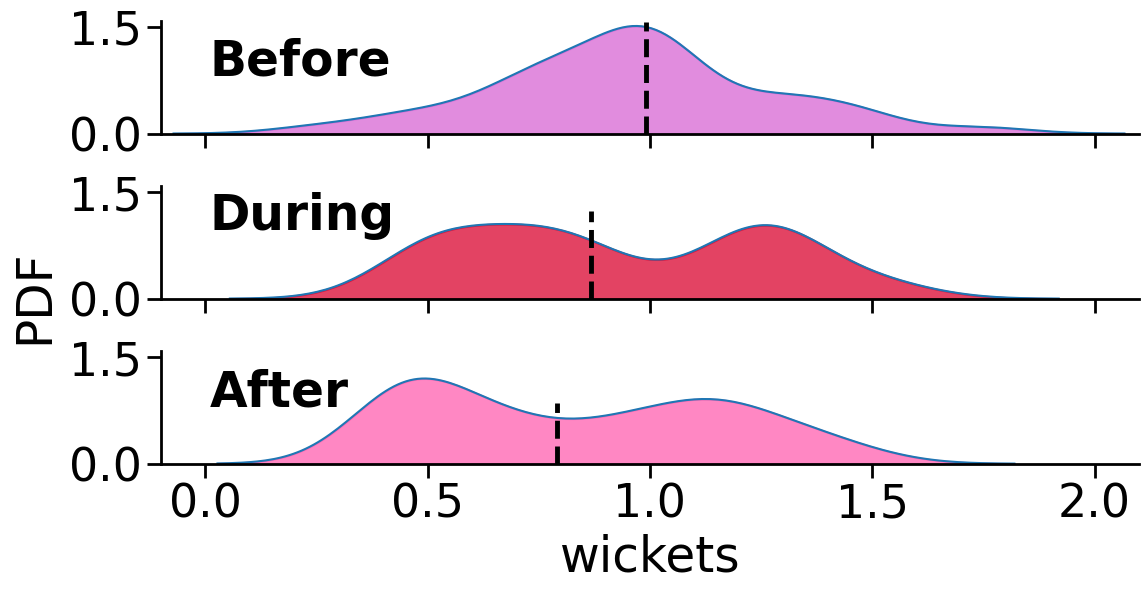

In [46]:
def captain_division_plot(min_career, norm_quant, category,  min_captain, bw_val):
    
    data = pd.read_pickle(generated_dat_path + f'captain_before_during_after_min_career_{min_career}_renorm_{norm_quant}_{category}_min_captain_{min_captain}.pkl')

    time_period = ['Before', 'During', 'After']

    # Creating a new figure
    fig, axes = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=True)
    # color_list = ['lightcoral', 'firebrick', 'indianred']#['#C56054', '#F2B035', '#54B0C5']

    if category == 'bat':
        color_list = ['sandybrown', 'darkorange', 'peru']
    elif category == 'bowl':
        color_list = ['orchid', 'crimson', 'hotpink']

    # Removing gridlines and ticks for the top two panels
    # for ax in axes:
    #     ax.grid(False)
    #     ax.set_yticks([])

    print(len(data[0]), len(data[1]), len(data[2]))
    print(np.count_nonzero(~np.isnan(data[0])), np.count_nonzero(~np.isnan(data[1])), np.count_nonzero(~np.isnan(data[2])))
    print('before-during: ', sp.stats.ttest_ind(data[0], data[1], nan_policy='omit').pvalue)
    print('during-after: ', ks_2samp(data[1], data[2]).pvalue)
    # print('before-after: ', ks_2samp(data[0], data[2]).pvalue)

    # Plotting the densities and the mean lines
    for i, tp in enumerate(time_period):

        cat_data = [x for x in data[i] if ~np.isnan(x)  and x > 0]
    
    
        sns.kdeplot(cat_data, fill=True, alpha=0.8, lw=1.5, bw_method=bw_val, ax=axes[i], color = color_list[i])
    
        # Calculating the mean and plotting a white line
        median_val = np.nanmedian(cat_data)
        mean_density = sns.kdeplot(cat_data, bw_method=bw_val, ax=axes[i]).get_lines()[0].get_data()
        
        # Find the index of the x-value closest to the mean
        ind = (np.abs(mean_density[0]-median_val)).argmin()
        
        y_val = mean_density[1][ind]/max(mean_density[1])
        
        axes[i].axvline(x = median_val, ymin=0, ymax=1*y_val, color='black', lw=3.5, ls='--')

        axis_decor(axes[i], text_font+3, 10, 5, 2)

        axes[i].set_ylabel('')

        if category == 'bat':
            axes[i].set_xlim(-5, 65)
            axes[i].set_xlabel('runs', fontsize=text_font+5)
        elif category == 'bowl':
            axes[i].set_xlim(-0.1, 2.1)
            axes[i].set_yticks([0, 1.5])
            axes[i].set_xlabel('wickets', fontsize=text_font+5)

        if category == 'bowl' and tp == 'During':
            axes[i].text(0.05, 0.95, tp, transform=axes[i].transAxes, fontsize=text_font+5, fontweight='bold', va='top', ha='left')
        else:
            axes[i].text(0.05, 0.85, tp, transform=axes[i].transAxes, fontsize=text_font+5, fontweight='bold', va='top', ha='left')

    fig.text(-0.04, 0.5, 'PDF', va='center', rotation='vertical', fontsize=text_font+5)
    plt.tight_layout()
    plt.savefig(prelim_fig_path + f'captain_division_min_career_{min_career}_renorm_{norm_quant}_{category}_min_captain_{min_captain}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    

captain_division_plot(min_career=25, norm_quant='Runs', category='bat', min_captain=15, bw_val=0.25)
captain_division_plot(min_career=25, norm_quant='Runs', category='bowl', min_captain=15, bw_val=0.35)